In [1]:
from PIL import Image
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle
import glob
import shutil
import os
%matplotlib inline

Скачиваем файлы

In [2]:
import gdown

url = "https://drive.google.com/drive/folders/1jzCr69swMFDgucO61s5WvK-lqo7sSICP?usp=drive_link"
zip_path = gdown.download_folder(url, quiet=True, use_cookies=False)[0]

In [4]:
zip_path

'/content/LoL_accept_button/DATA.zip'

In [3]:
!unzip -q $zip_path

In [5]:
current_directory = os.getcwd()

In [6]:
annotations_path = glob.glob(f"{current_directory}/DATA/Annotations/*")
pictures_path = glob.glob(f"{current_directory}/DATA/Pictures/*")

In [7]:
annotations_path = sorted(annotations_path)
pictures_path = sorted(pictures_path)

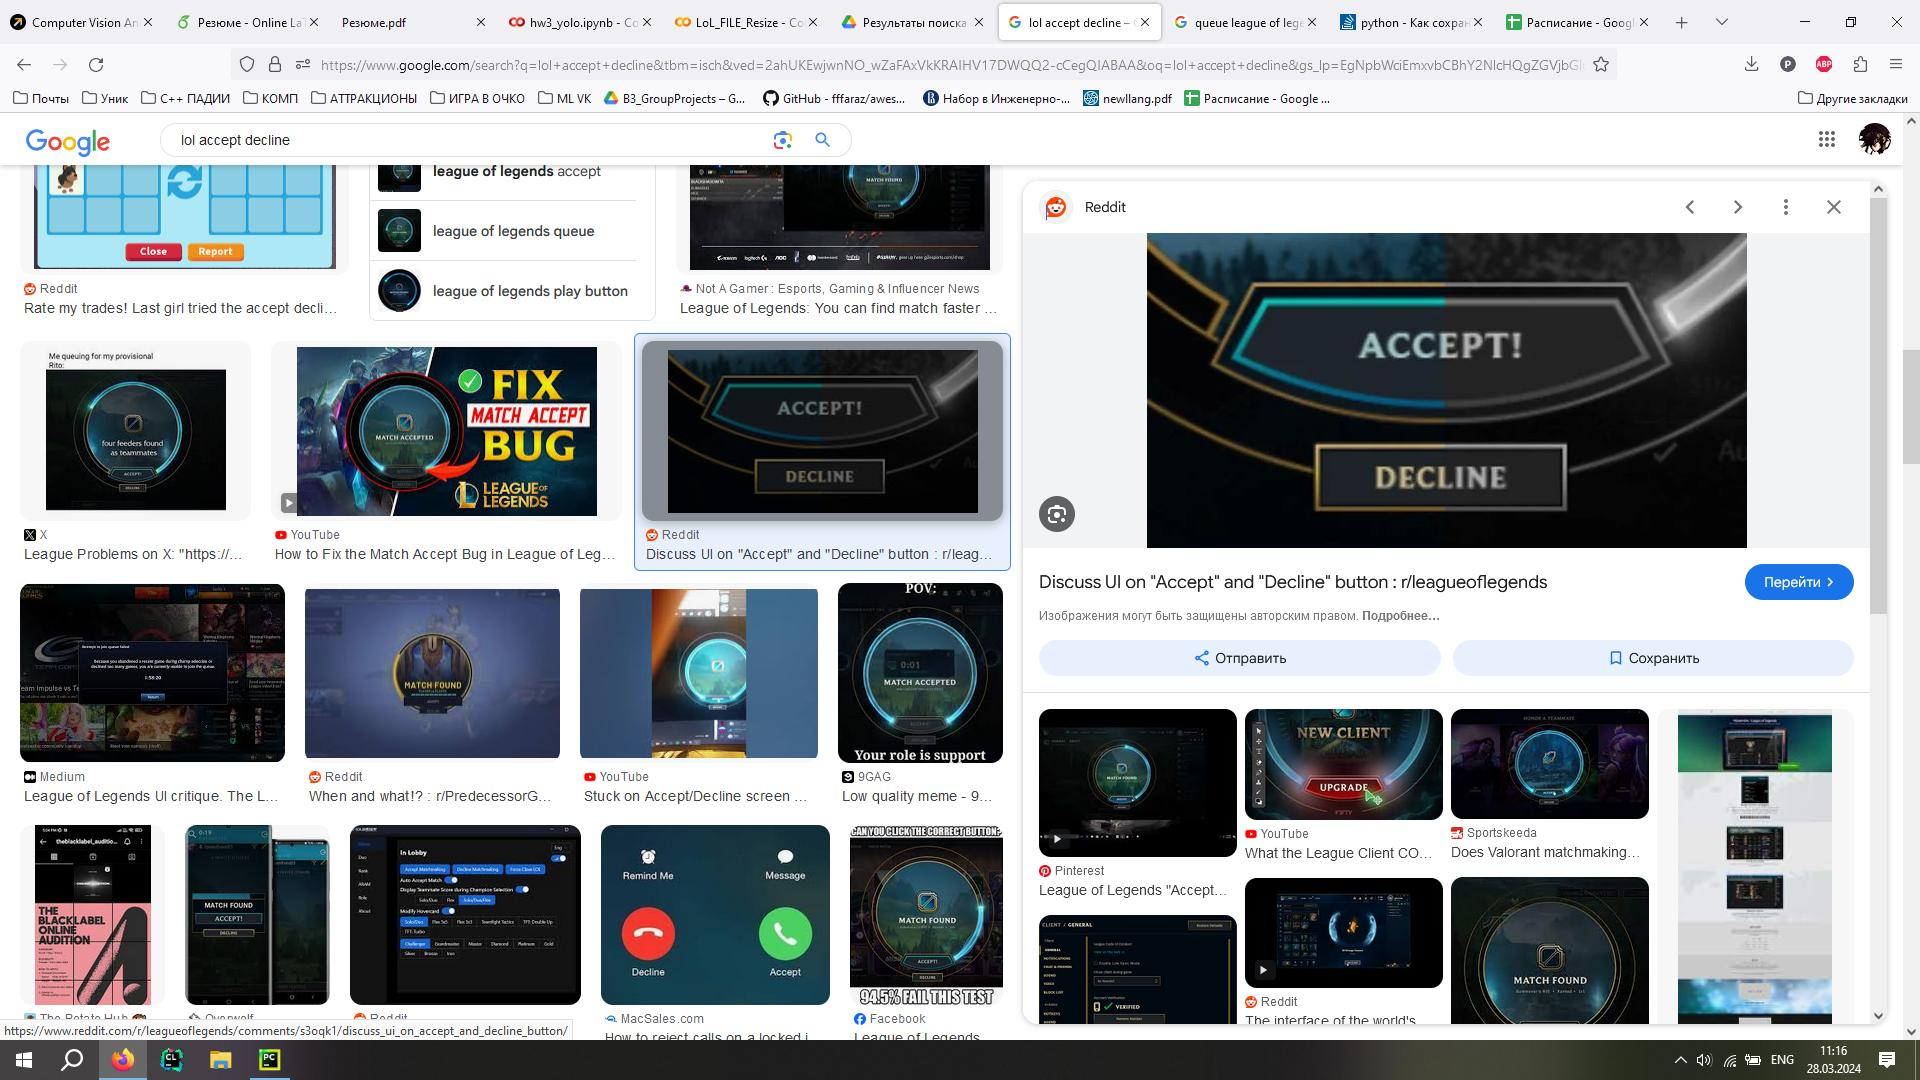

In [8]:
treshold_name = pictures_path[19]
example_image = Image.open(treshold_name)

In [9]:
coded_class_dict = {"accept_button":0}
decoded_class_dict = {0:"accept_button"}

In [10]:
def get_xml_data(annotation_path, class_dict):
    '''
    func to parse XML file and get bboxes of accept_buttons
    '''
    tree = ET.parse(annotation_path)
    treeroot = tree.getroot()
    bboxes = []
    for member in treeroot.findall("object"):
        res = [
            int(float(member.find("bndbox/xmin").text)),
            int(float(member.find("bndbox/ymin").text)),
            int(float(member.find("bndbox/xmax").text)),
            int(float(member.find("bndbox/ymax").text)),
            class_dict[member.find("name").text]
            ]
        bboxes.append(res)

    return bboxes

In [12]:
def show(picture_path, annotation_path):
    '''
    func to visualize pictures with labeled bboxes from train
    '''
    if not isinstance(annotation_path, str):
        bboxes = annotation_path
    else:
        bboxes = get_xml_data(annotation_path, coded_class_dict)
    fig, ax = plt.subplots(figsize=(20, 12))
    img = mpimg.imread(picture_path)
    plt.imshow(img)
    for bbox in bboxes:
        bbox = list(map(int, bbox))
        ax.add_patch(Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1],
                    edgecolor = 'blue',
                    fill=False,
                    lw=2))
    plt.show()

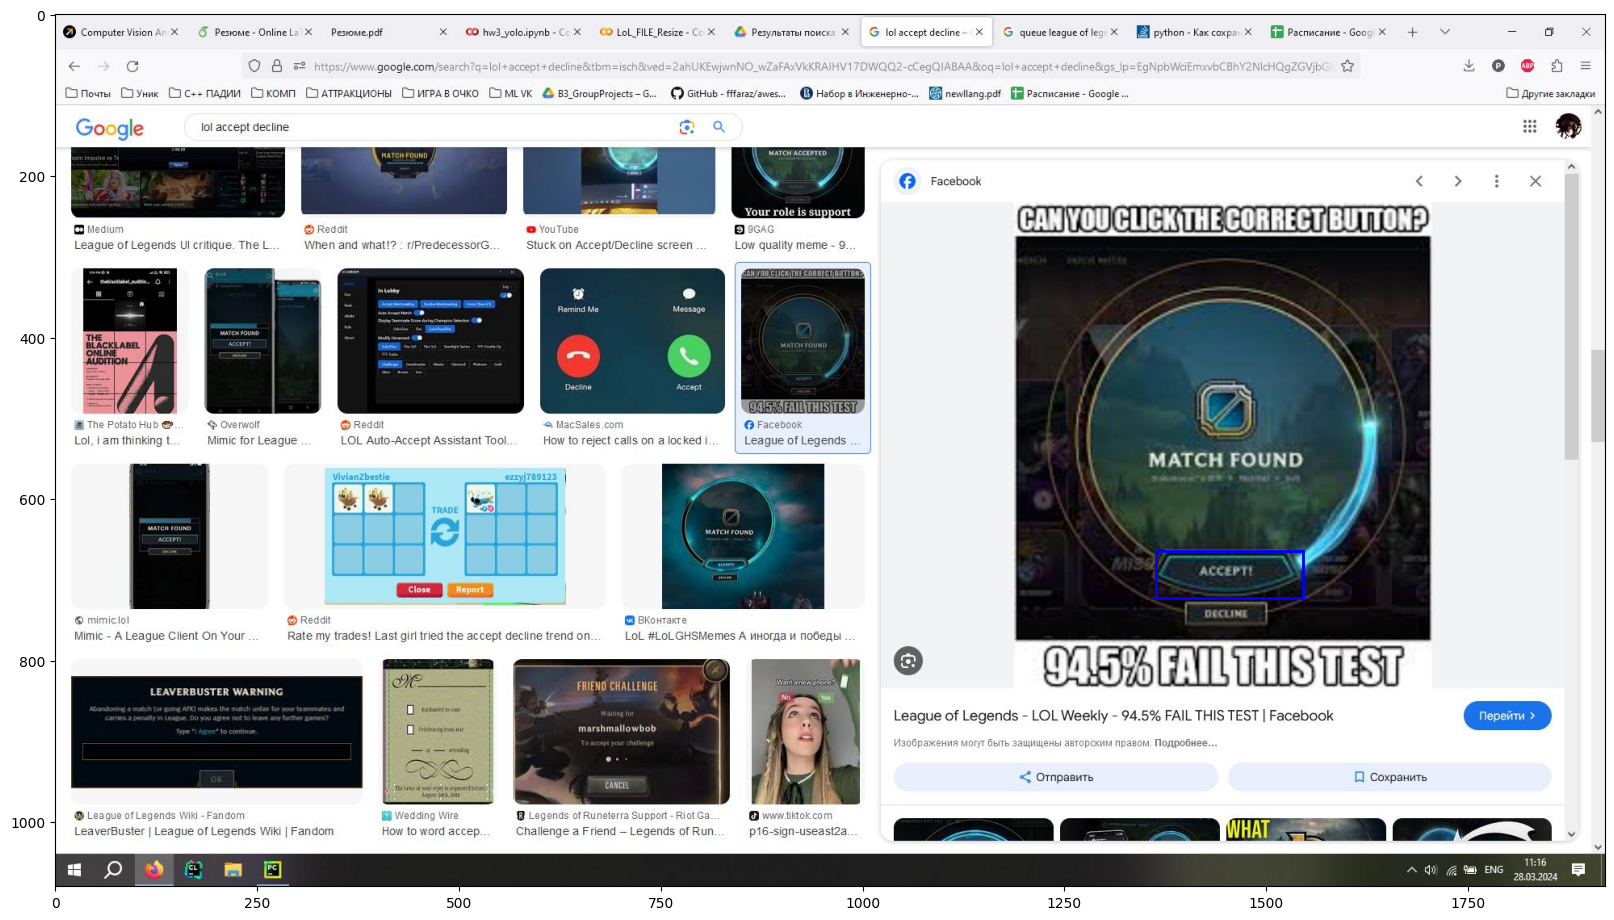

In [13]:
number = 25
show(pictures_path[number], annotations_path[number])

Скачиваем yolo8 и обучаем на размеченных данных

In [14]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 723.1/723.1 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 19.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 68.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 81.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [15]:
!rm -rf train
!rm -rf valid
!mkdir -p train/images train/labels valid/images valid/labels

In [16]:
def annotation2txt(bboxes, w_im, h_im):
    res = []
    for bbox in bboxes:
        class_id = bbox[4]
        center_x = (bbox[0]+bbox[2])/(2*w_im)
        center_y = (bbox[1]+bbox[3])/(2*h_im)
        width    = (bbox[2]-bbox[0])/w_im
        height   = (bbox[3]-bbox[1])/h_im
        res.append(f"{class_id} {center_x} {center_y} {width} {height}")
    return res

In [17]:
train_image_n = len(pictures_path)*8//10

for i in range(train_image_n):
    result = pictures_path[i], get_xml_data(annotations_path[i], coded_class_dict)
    shutil.copyfile(
        result[0], "./train/images/" + result[0].split("/")[-1],
    )
    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./train/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

for i in range(train_image_n, len(pictures_path)):
    result = pictures_path[i], get_xml_data(annotations_path[i], coded_class_dict)
    shutil.copyfile(
        result[0], "./valid/images/" + result[0].split("/")[-1],
    )
    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./valid/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

In [18]:
names = ["accept_button"]
with open("data.yaml", "w") as f:
    f.write(f"train: ../train/images\nval: ../valid/images\n\nnc: {1}\nnames: {names}")

In [19]:
import ultralytics

model   = ultralytics.YOLO('yolov8n.yaml')
results = model.train(data='data.yaml', epochs=100, imgsz=512, save = True)

Ultralytics YOLOv8.1.37 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.yaml, data=data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, li

100%|██████████| 755k/755k [00:00<00:00, 24.3MB/s]


Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 124MB/s]


AMP: checks passed ✅


train: Scanning /content/train/labels... 214 images, 74 backgrounds, 0 corrupt: 100%|██████████| 214/214 [00:00<00:00, 2238.41it/s]

train: New cache created: /content/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/valid/labels... 54 images, 13 backgrounds, 0 corrupt: 100%|██████████| 54/54 [00:00<00:00, 945.39it/s]

val: New cache created: /content/valid/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 512 train, 512 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100       1.6G      5.819      32.24      4.039          7        512: 100%|██████████| 14/14 [00:08<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.18s/it]

                   all         54         51          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100       1.6G      5.596      15.35      4.135          6        512: 100%|██████████| 14/14 [00:03<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]

                   all         54         51          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100       1.6G      6.005      17.31      3.966          5        512: 100%|██████████| 14/14 [00:04<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]

                   all         54         51          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      1.61G      4.582      8.117      3.672          6        512: 100%|██████████| 14/14 [00:03<00:00,  3.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         54         51          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100       1.6G      4.248      7.957      3.092         12        512: 100%|██████████| 14/14 [00:04<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

                   all         54         51          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      1.61G      3.921      6.023      2.803          4        512: 100%|██████████| 14/14 [00:03<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         54         51          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      1.61G       3.71      4.925      2.482         12        512: 100%|██████████| 14/14 [00:04<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]

                   all         54         51          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      1.61G      3.476      4.612      2.428         10        512: 100%|██████████| 14/14 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.11it/s]

                   all         54         51    0.00392      0.569     0.0235    0.00453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      1.61G      3.263      4.269      2.227         14        512: 100%|██████████| 14/14 [00:03<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.57it/s]

                   all         54         51    0.00461      0.471     0.0548     0.0127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      1.61G      3.195      4.229      2.146          7        512: 100%|██████████| 14/14 [00:04<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all         54         51     0.0134      0.235     0.0767     0.0298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      1.61G      2.951      3.755      2.137          8        512: 100%|██████████| 14/14 [00:03<00:00,  3.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.10it/s]

                   all         54         51       0.16      0.176      0.103     0.0279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      1.61G      2.775      3.365      1.928          7        512: 100%|██████████| 14/14 [00:05<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

                   all         54         51      0.259      0.412      0.206     0.0489



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      1.61G      2.637      3.503      1.944          7        512: 100%|██████████| 14/14 [00:03<00:00,  3.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]

                   all         54         51      0.273       0.51      0.264      0.108



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      1.61G       2.43      3.332      1.728          5        512: 100%|██████████| 14/14 [00:08<00:00,  1.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.92it/s]

                   all         54         51      0.314      0.451      0.267      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      1.61G      2.446      3.138      1.771          7        512: 100%|██████████| 14/14 [00:05<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]

                   all         54         51      0.293      0.471      0.317      0.154



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      1.61G      2.468      2.825      1.876          6        512: 100%|██████████| 14/14 [00:03<00:00,  3.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]

                   all         54         51       0.56      0.627      0.517      0.212



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      1.61G      2.349      2.586      1.753          4        512: 100%|██████████| 14/14 [00:04<00:00,  2.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.37it/s]

                   all         54         51      0.503      0.496       0.44      0.175



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      1.61G      2.299      2.452      1.621          8        512: 100%|██████████| 14/14 [00:04<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.46it/s]

                   all         54         51      0.651      0.549      0.494      0.204



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      1.61G      2.043      2.207      1.568          8        512: 100%|██████████| 14/14 [00:05<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]

                   all         54         51      0.615      0.608      0.514      0.218



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      1.61G      2.003      1.962      1.538          6        512: 100%|██████████| 14/14 [00:03<00:00,  3.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]

                   all         54         51      0.643      0.742      0.633      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      1.61G       2.07      2.015      1.449          7        512: 100%|██████████| 14/14 [00:04<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.17it/s]

                   all         54         51      0.641      0.735      0.553       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      1.61G      2.108      1.934      1.487          7        512: 100%|██████████| 14/14 [00:04<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]

                   all         54         51      0.621       0.74      0.656      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      1.61G      2.013      1.945      1.488          7        512: 100%|██████████| 14/14 [00:04<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]

                   all         54         51      0.621      0.549      0.599      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      1.61G      2.095      2.017      1.461          4        512: 100%|██████████| 14/14 [00:04<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.76it/s]

                   all         54         51      0.666      0.625      0.657      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      1.61G      1.834       1.83      1.477          5        512: 100%|██████████| 14/14 [00:05<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]

                   all         54         51      0.695      0.706      0.642      0.356



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      1.61G      1.819      1.752      1.393          5        512: 100%|██████████| 14/14 [00:03<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]

                   all         54         51      0.767      0.706      0.636      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      1.61G       1.75      1.624      1.324          9        512: 100%|██████████| 14/14 [00:05<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.23it/s]

                   all         54         51      0.774      0.608      0.647      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      1.61G      1.817      1.691      1.551          2        512: 100%|██████████| 14/14 [00:04<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]

                   all         54         51      0.807      0.725      0.738      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      1.61G      1.746      1.557      1.411          7        512: 100%|██████████| 14/14 [00:04<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.71it/s]

                   all         54         51       0.83      0.575      0.713      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      1.61G      1.684      1.554      1.279          8        512: 100%|██████████| 14/14 [00:04<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.28it/s]

                   all         54         51      0.714      0.686      0.743      0.351



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      1.61G      1.756      1.571       1.36          7        512: 100%|██████████| 14/14 [00:04<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]

                   all         54         51       0.78      0.686      0.757      0.388



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      1.61G      1.713       1.46      1.291          8        512: 100%|██████████| 14/14 [00:04<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

                   all         54         51      0.824      0.641      0.737      0.431



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      1.61G      1.577      1.413      1.237          6        512: 100%|██████████| 14/14 [00:05<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.20it/s]

                   all         54         51      0.818      0.765      0.778      0.421



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      1.61G      1.736      1.481      1.315          6        512: 100%|██████████| 14/14 [00:04<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

                   all         54         51      0.751      0.686      0.696      0.378



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      1.61G      1.545      1.239      1.212          8        512: 100%|██████████| 14/14 [00:05<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]

                   all         54         51      0.741      0.725      0.761       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      1.61G      1.635      1.278      1.238          7        512: 100%|██████████| 14/14 [00:04<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.76it/s]

                   all         54         51      0.744      0.796      0.735      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      1.61G      1.606      1.296      1.224          7        512: 100%|██████████| 14/14 [00:05<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]

                   all         54         51      0.808      0.765      0.761      0.413



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      1.61G      1.489      1.228      1.167          5        512: 100%|██████████| 14/14 [00:04<00:00,  3.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.21it/s]

                   all         54         51      0.808      0.765      0.789      0.437



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      1.61G      1.567      1.266      1.263         12        512: 100%|██████████| 14/14 [00:04<00:00,  2.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

                   all         54         51      0.828      0.765      0.886       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      1.61G       1.52      1.255      1.232         10        512: 100%|██████████| 14/14 [00:03<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]

                   all         54         51      0.818      0.765      0.842      0.366



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      1.61G      1.566      1.319      1.215          7        512: 100%|██████████| 14/14 [00:05<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.28it/s]

                   all         54         51      0.821      0.745      0.767       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      1.61G      1.505      1.208      1.182          4        512: 100%|██████████| 14/14 [00:03<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]

                   all         54         51       0.79      0.765      0.773      0.466



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      1.61G       1.42      1.165      1.174          9        512: 100%|██████████| 14/14 [00:05<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.73it/s]

                   all         54         51       0.84      0.745      0.811       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      1.61G       1.51      1.199      1.178          7        512: 100%|██████████| 14/14 [00:04<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.30it/s]

                   all         54         51       0.79      0.736      0.855      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      1.61G      1.468      1.325      1.212          5        512: 100%|██████████| 14/14 [00:05<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.93it/s]

                   all         54         51      0.801      0.686      0.805      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      1.61G      1.371      1.126      1.175          8        512: 100%|██████████| 14/14 [00:05<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.86it/s]

                   all         54         51      0.824      0.765      0.855      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      1.61G      1.385      1.137      1.166          6        512: 100%|██████████| 14/14 [00:04<00:00,  3.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]

                   all         54         51      0.836      0.745       0.86      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      1.61G       1.56      1.248      1.221          6        512: 100%|██████████| 14/14 [00:07<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.28it/s]

                   all         54         51       0.77      0.765      0.841      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      1.61G      1.456      1.138       1.15          8        512: 100%|██████████| 14/14 [00:07<00:00,  1.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.31it/s]

                   all         54         51      0.818      0.765      0.851      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      1.61G      1.531      1.172      1.182          7        512: 100%|██████████| 14/14 [00:06<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         54         51      0.712      0.961      0.834      0.432



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      1.61G      1.439      1.157       1.13          9        512: 100%|██████████| 14/14 [00:07<00:00,  1.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]

                   all         54         51      0.751      0.961      0.916       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      1.61G      1.432      1.065      1.134          6        512: 100%|██████████| 14/14 [00:05<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.74it/s]

                   all         54         51      0.806      0.734      0.862      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      1.61G      1.403      1.056      1.177          7        512: 100%|██████████| 14/14 [00:03<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]

                   all         54         51      0.831      0.804      0.936      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      1.61G      1.407      1.062      1.201          9        512: 100%|██████████| 14/14 [00:04<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.86it/s]

                   all         54         51      0.738          1      0.901      0.453



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      1.61G      1.427      1.055      1.183          8        512: 100%|██████████| 14/14 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]

                   all         54         51      0.737      0.823      0.875      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      1.61G      1.386      1.014      1.119         12        512: 100%|██████████| 14/14 [00:05<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.05it/s]


                   all         54         51      0.799      0.781      0.926      0.552

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      1.61G      1.352      1.028      1.094         10        512: 100%|██████████| 14/14 [00:03<00:00,  3.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]

                   all         54         51        0.8      0.961       0.92      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      1.61G      1.391      1.006      1.111          7        512: 100%|██████████| 14/14 [00:06<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.27it/s]

                   all         54         51      0.799      0.961      0.912        0.5



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      1.61G      1.374     0.9665      1.108          5        512: 100%|██████████| 14/14 [00:04<00:00,  3.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]

                   all         54         51      0.792      0.972      0.922      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      1.61G      1.446      1.034      1.098         10        512: 100%|██████████| 14/14 [00:05<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.08it/s]

                   all         54         51      0.783          1      0.938      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      1.61G      1.421      1.054      1.138          7        512: 100%|██████████| 14/14 [00:04<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.99it/s]

                   all         54         51      0.793          1      0.942      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      1.61G      1.416      1.014      1.164          9        512: 100%|██████████| 14/14 [00:05<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.85it/s]

                   all         54         51      0.776      0.961      0.918      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      1.61G      1.358     0.9928      1.158          7        512: 100%|██████████| 14/14 [00:04<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]

                   all         54         51      0.795       0.98      0.941      0.474



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      1.63G      1.289      1.022      1.121          4        512: 100%|██████████| 14/14 [00:04<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]

                   all         54         51      0.843      0.946      0.928      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      1.61G      1.247     0.9261      1.119          6        512: 100%|██████████| 14/14 [00:05<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]

                   all         54         51      0.798      0.961      0.905      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      1.61G      1.337     0.9389      1.089          3        512: 100%|██████████| 14/14 [00:04<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.80it/s]

                   all         54         51      0.728      0.902      0.831      0.393



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      1.61G      1.337     0.8742       1.09          7        512: 100%|██████████| 14/14 [00:05<00:00,  2.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         54         51      0.821      0.721      0.795      0.362



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      1.61G      1.365      0.898      1.079          4        512: 100%|██████████| 14/14 [00:04<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.94it/s]

                   all         54         51       0.81      0.941       0.93      0.512



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      1.61G      1.262     0.9439      1.101          3        512: 100%|██████████| 14/14 [00:04<00:00,  2.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.91it/s]

                   all         54         51      0.761      0.882      0.872      0.396



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      1.61G      1.339      1.045      1.122          3        512: 100%|██████████| 14/14 [00:03<00:00,  3.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.53it/s]

                   all         54         51      0.745      0.918      0.902      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      1.61G      1.298     0.9556       1.14          4        512: 100%|██████████| 14/14 [00:04<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]

                   all         54         51       0.79      0.765      0.869      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      1.61G      1.312     0.9321       1.13          5        512: 100%|██████████| 14/14 [00:04<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.97it/s]

                   all         54         51      0.789      0.809      0.905      0.433



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      1.61G      1.202     0.9081      1.041         13        512: 100%|██████████| 14/14 [00:05<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]

                   all         54         51          1      0.639      0.854      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      1.61G      1.224     0.8512      1.051          7        512: 100%|██████████| 14/14 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  4.29it/s]

                   all         54         51      0.797      0.768      0.911      0.443



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      1.61G      1.265     0.9643      1.082          8        512: 100%|██████████| 14/14 [00:05<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]

                   all         54         51      0.845      0.765      0.795      0.408



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      1.61G      1.273     0.8848      1.052          7        512: 100%|██████████| 14/14 [00:04<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.12it/s]

                   all         54         51      0.843      0.765      0.768      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      1.62G      1.219      1.003      1.078          6        512: 100%|██████████| 14/14 [00:05<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.88it/s]

                   all         54         51      0.775      0.804      0.923      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      1.61G      1.199     0.8697      1.059          8        512: 100%|██████████| 14/14 [00:05<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         54         51      0.809      0.804      0.877       0.49



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      1.61G      1.243     0.9293      1.066          7        512: 100%|██████████| 14/14 [00:04<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.75it/s]

                   all         54         51      0.816      0.804       0.84      0.423



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      1.61G      1.193     0.8867      1.074         13        512: 100%|██████████| 14/14 [00:05<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.33it/s]

                   all         54         51      0.816      0.784      0.878      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      1.61G      1.206      0.875       1.07          7        512: 100%|██████████| 14/14 [00:06<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]

                   all         54         51      0.769      0.961      0.915      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      1.61G      1.213     0.8997      1.144          8        512: 100%|██████████| 14/14 [00:05<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]

                   all         54         51      0.833      0.783       0.91      0.467



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      1.61G      1.227      0.884      1.037          6        512: 100%|██████████| 14/14 [00:05<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.99it/s]

                   all         54         51      0.843      0.765      0.876      0.434



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      1.61G      1.123     0.8431      1.051         11        512: 100%|██████████| 14/14 [00:07<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.56it/s]

                   all         54         51      0.763      0.961      0.927      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      1.61G      1.159     0.8622      1.079          4        512: 100%|██████████| 14/14 [00:06<00:00,  2.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]

                   all         54         51      0.797      0.961      0.927      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      1.61G      1.134     0.8523      1.063          6        512: 100%|██████████| 14/14 [00:05<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.02s/it]

                   all         54         51      0.811      0.961      0.927      0.451



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      1.63G      1.204     0.8255      1.097          5        512: 100%|██████████| 14/14 [00:04<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]

                   all         54         51      0.828      0.946      0.924      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      1.61G      1.122     0.8297      1.023         12        512: 100%|██████████| 14/14 [00:04<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]

                   all         54         51       0.83      0.804       0.92      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      1.61G      1.238     0.8512      1.098          7        512: 100%|██████████| 14/14 [00:04<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.03it/s]

                   all         54         51      0.833      0.804      0.918      0.487



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      1.61G      1.134     0.7938      1.083         11        512: 100%|██████████| 14/14 [00:05<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.57it/s]

                   all         54         51      0.832      0.804      0.886       0.42


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      1.61G      1.117     0.8409      1.035          6        512: 100%|██████████| 14/14 [00:07<00:00,  1.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.31it/s]

                   all         54         51      0.816      0.784      0.881       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      1.61G      1.226     0.9066      1.076          5        512: 100%|██████████| 14/14 [00:05<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.78it/s]

                   all         54         51      0.864      0.765      0.889      0.492



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      1.61G      1.115     0.8526      1.025          5        512: 100%|██████████| 14/14 [00:03<00:00,  3.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.39it/s]

                   all         54         51      0.792      0.961      0.932      0.462



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      1.61G      1.144     0.8721      1.058          3        512: 100%|██████████| 14/14 [00:04<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.30it/s]

                   all         54         51      0.789       0.98      0.933       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      1.61G      1.075     0.8366      1.036          4        512: 100%|██████████| 14/14 [00:04<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.79it/s]

                   all         54         51      0.791          1       0.94      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      1.61G      1.112     0.8397      1.044          4        512: 100%|██████████| 14/14 [00:04<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.68it/s]

                   all         54         51      0.809      0.998      0.939      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      1.61G      1.067      0.854      1.053          4        512: 100%|██████████| 14/14 [00:04<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]

                   all         54         51      0.784          1      0.938      0.515



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      1.61G      1.011     0.7994      1.011          4        512: 100%|██████████| 14/14 [00:07<00:00,  1.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.79it/s]

                   all         54         51      0.782          1       0.93      0.495



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      1.61G      1.108     0.8794     0.9944          2        512: 100%|██████████| 14/14 [00:05<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.27it/s]

                   all         54         51      0.783          1      0.928      0.499



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      1.61G      1.009     0.7942     0.9781          4        512: 100%|██████████| 14/14 [00:04<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.40it/s]

                   all         54         51      0.788          1       0.93      0.513



100 epochs completed in 0.200 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics YOLOv8.1.37 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3005843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.72it/s]


                   all         54         51        0.8      0.961       0.92      0.566
Speed: 0.2ms preprocess, 1.8ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/train


In [22]:
results = model(f"{current_directory}/League_sceenshot.jpg")


image 1/1 /content/League_sceanshot.jpg: 320x512 1 accept_button, 97.6ms
Speed: 2.2ms preprocess, 97.6ms inference, 2.7ms postprocess per image at shape (1, 3, 320, 512)


Протестируем на случайном изображении

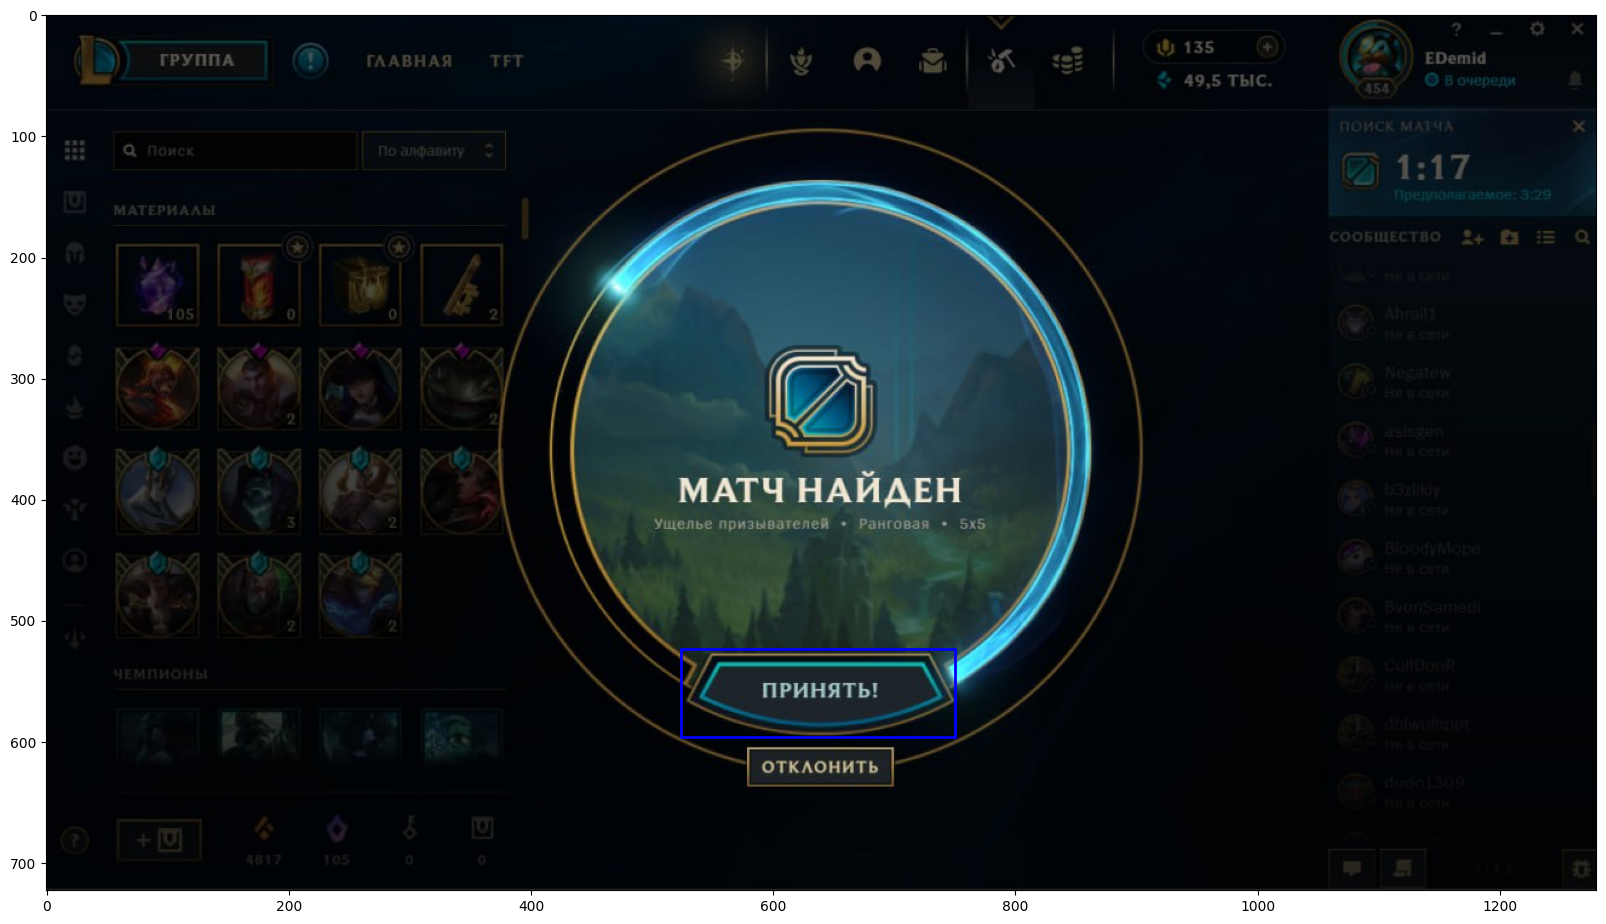

In [24]:
show(f"{current_directory}/League_sceenshot.jpg", results[0].boxes.xyxy.tolist())

In [25]:
from google.colab import files
files.download(f'{current_directory}/runs/detect/train/weights/best.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>